### Go to https://nbviewer.org/github/tjbuck11/NYC-Living-Optimization/blob/main/NYC_Living_Notebook.ipynb to see the interactive maps

In [1]:
!pip install numpy folium pandas utm matplotlib

  DEPRECATION: utm is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559

[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: C:\Users\thoma\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



     -------------------------------------- 102.3/102.3 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py install for utm: started
  Running setup.py install for utm: finished with status 'done'


# Where Should I Live in New York City? 
**By Thomas Buck**

## Problem Description

I accepted an internship based in New York City for this summer, so I must find a place to live for  about 3 months. I will either sublet an apartment or reside in dorm-style living at a nearby university or private company. However, New York is a massive city with many different neighborhoods, and my housing location could either be the biggest convenience or inconvenience. My goal is to find the most convenient location to live that is within my rent budget and also determine my method of travel to each location within my transportation budget. 

Originally, I believed a facility location problem would be the best model choice to address this situation. However, finding all the possible locations I could live in New York would take countless hours to accomplish as there are hundreds if not thousands of different apartment buildings throughout Manhattan. Since this option isn't feasible, I decided to take a hierarchical goal programming approach. Another benefit to using this is I can easily account for the cost of my rent, which I originally believed was too difficult to include. This method would address each situation efficiently in a three stage process.

The first stage determines which neighborhood to live in based on my rent budget and total distance to all the locations I must travel to. Splitting this into the first stage allows me to create a model that determines the optimal neighborhood to live in without too much complexity. Each NYC neighborhood will be represented by it's centroid, and distances will be computed from each neighborhood to each location. This is arguably the most important goal since rent will account for a large majority of my incurred costs while living in New York. The model will be a mixed integer program with a binary variable representing which neighborhood I should live in.

The second stage determines exactly where I should live within the optimal neighborhood. To do so, I will formulate the problem similar to a Sylvester Optimization Model, where my living quarters will minimize my total distance to all locations (and account for the locations priority as well). This will allow me to minimize my distance traveled, while keeping my rent within my budget. This is a quadratically constrained optimization problem due to the distance formulation and will be solved using the qcp solver CPLEX.  

Finally, the third stage will take the optimal location to live and convert distances into costs and times based on my method of transportation. The model will then minimize the total transportation time while keeping my transportation costs within my budget. This will also be a mixed integer program since the formulations for cost and time are linear and I will have a binary variable determining which transportation method I take to each location.

Each stage will be labeled clearly and all data utilized will be displayed. Additionally, each model contains a formulation with the objective function and the constraints the problem is subjected to. 

\**Also, all the maps within this workbook are interactive, so feel free to zoom in to get a closer look at the locations. You can also hover over elements of the map such as points, regions, or lines and text will pop up denoting what this object is referring to (but regions must be clicked on). If you get too off center or the zoom is odd, rerun the cell and it should recenter your location and the zoom level (however, make sure you rerun the cells before it so it displays the proper map from the previous model).*

## General Data

The data for this project was generated through google map searches to find locations I want to be close to in Manhattan. I recorded the geographical coordinates for each location from google maps. A description of each location can be found below:

- **West Monroe NYC Office**: Work location for next summer
- **CitiGroup Headquarters**: My girlfriends work location for next summer
- **NYU Gym**: New York University Athletic Facility
- **Targets**: 3 Target locations for groceries and convenience products
- **Whole Foods**: 3 Whole Foods locations for organic and specialty groceries
- **Starbucks**: 3 Starbucks locations for coffee and convenient breakfast foods
- **Bars**: 2 bars for weekends and socializing
- **Burger Restaurant**: Restaurant specializing in hamburgers (my favorite food)
- **Italian Restaurant**: Upscale restaurant for date nights
- **Pizza**: Restaurant serving cheap pizza for convenience
- **Chinese Restaurant**: For Chinese food cravings
- **Subway Stops**: 5 all-train subway stops

Each location's geographic coordinates are converted to UTM coordinates (which closely model cartesian coordinates) with miles as the units. The Euclidean distance formulation between two UTM coordinates is an accurate approximation for the true distance over small areas (distances less than 100 km) and since the data is clustered around Manhattan, using Euclidean distance to approximate the true distance between two points is supported. 

Locations are represented by a set denoted by $ \ell $ and the coordinates are denoted as a set $x, y$ where $x$ and $y$ are the corresponding Easting and Northing UTM coordinates, respectively. Additionally, let the parameter $data_{\ell xy}$ refer to the coordinates for each location.

Additionally, each location has a relative weight associated with it. This value is assigned entirely by the modeler who must determine which locations are most important to them. I constructed these weights by thinking about my frequency of travel to the specific location in a given week and my own priority of the location (I also partially considered my girlfriends priorities). Not all locations will be traveled to in a given week or at that frequency, so the final distances (in miles) given by the models should not be taken at face value. However, I want to include all of these locations to ensure I am as close as possible to anything I may need while in Manhattan. The weights are denoted as a parameter referred to as $ w_\ell $. Traveling to a location entails traveling back to where I live, so the weights take this into account.

Therefore, all locations were assigned a **weight of 2** except for the ones noted below:

- Work 5 days in person each week : $w_{west\:monroe}$ **= 10** 
- Partial priority to my girlfriends workplace : $w_{citi}$ **= 6**
- Travel to a Target an average of 2 times per week: $w_{targets_{123}}$ = **4**
- Workout 5 days per week : $w_{gym}$ **= 10**
- Priority on restaurant with my favorite food : $w_{burger}$ **= 4**
- Subways for transportation convenience : $w_{subway_{12345}}$ **= 6**

In [4]:
locations = {}
locations['West_Monroe'] = [40.76232991564732, -73.986986204738610]
locations['Citi'] = [40.72082663801494, -74.01123926055867]
locations['Gym'] = [40.730340053199775, -73.99232238436313]
locations['Target1'] = [40.77099289872144, -73.98262251152796]
locations['Target2'] = [40.758198636660595, -73.98865085566145]
locations['Target3'] = [40.750981657074426, -73.98873668635203]
locations['WholeFoods1'] = [40.755402962753465, -73.98478847458593]
locations['WholeFoods2'] = [40.74553546296837, -73.99518193485794]
locations['WholeFoods3'] = [40.76092181643819, -73.96605465989782]
locations['Coffee1'] = [40.76325954898913, -73.98373579452061]
locations['Coffee2'] = [40.75699780802759, -73.9911013833663]
locations['Coffee3'] = [40.74323876597697, -73.9934468792767]
locations['Bar1'] = [40.75376842347931, -73.9914269877785]
locations['Bar2'] = [40.73860048503158, -73.98884854471974]
locations['Restaurant_Burger'] = [40.760726730364134, -73.99072764088578]
locations['Restaurant_Italian'] = [40.76156905182467, -73.9865630861668]
locations['Restaurant_Pizza'] = [40.755358465987854, -73.98709519866223]
locations['Restaurant_Chinese'] = [40.762512460267274, -73.99110755515065]
locations['Subway1'] = [40.76222794478111, -73.98414809616249]
locations['Subway2'] = [40.748864641487344, -73.9932415413149]
locations['Subway3'] = [40.7346718017468, -73.99997069072771]
locations['Subway4'] = [40.73327000874273, -73.9910734043118]
locations['Subway5'] = [40.72528852193325, -74.00753032859059]

import utm
location_2 = {}
for i in locations:
    x, y, zone, u = utm.from_latlon(locations[i][0], locations[i][1])
    location_2[i] = (x/1609,y/1609)

weights = {}
weights['West_Monroe'] = 10
weights['Citi'] = 6
weights['Gym'] = 10
weights['Target1'] = 4
weights['Target2'] = 4
weights['Target3'] = 4
weights['WholeFoods1'] = 2
weights['WholeFoods2'] = 2
weights['WholeFoods3'] = 2
weights['Coffee1'] = 2
weights['Coffee2'] = 2
weights['Coffee3'] = 2
weights['Bar1'] = 2
weights['Bar2'] = 2
weights['Restaurant_Burger'] = 4
weights['Restaurant_Italian'] = 2
weights['Restaurant_Pizza'] = 2
weights['Restaurant_Chinese'] = 2
weights['Subway1'] = 6
weights['Subway2'] = 6
weights['Subway3'] = 6
weights['Subway4'] = 6
weights['Subway5'] = 6

## Stage 1: Determining a Neighborhood

There are a vast array of neighborhoods in New York, all of which have different costs of living. The data for these regions and their respective boundaries were collected from a geojson file found on [nyc.gov](https://www.nyc.gov/site/planning/data-maps/open-data/census-download-metadata.page) about neighborhood tabulation areas used for the 2020 census tracking. I cleaned the geojson file to only include regions in Lower Manhattan since most of the locations determined above are in the Lower Manhattan region. These neighborhoods include: 

- Financial District-Battery Park City
- Tribeca-Civic Center
- The Battery-Governors Island-Ellis Island-Liberty Island
- SoHo-Little Italy-Hudson Square
- Greenwich Village
- West Village
- Chinatown-Two Bridges
- Lower East Side
- East Village
- Chelsea-Hudson Yards
- Hell's Kitchen
- Midtown South-Flatiron-Union Square
- Midtown-Times Square
- Stuyvesant Town-Peter Cooper Village
- Gramercy
- Murray Hill-Kips Bay
- East Midtown-Turtle Bay
- Upper West Side-Lincoln Square
- Upper West Side (Central)
- Upper West Side-Manhattan Valley
- Upper East Side-Lenox Hill-Roosevelt Island
- Upper East Side-Carnegie Hill
- Upper East Side-Yorkville

The set of neighborhoods will be denoted by $n$. A visualization of these neighborhoods and the coordinates of each location in $\ell$ can be found below.

In [5]:
import json
import folium

f = open("Bounds2.geojson")
data = json.load(f)
new_json = {'type': 'FeatureCollection','features': []}
for i in range(len(data['features'])):
    if data['features'][i]['properties']['BoroName'] == 'Manhattan':
        if (data['features'][i]['properties']['NTAName'] == 'Financial District-Battery Park City'
            or data['features'][i]['properties']['NTAName'] == 'Tribeca-Civic Center'
            or data['features'][i]['properties']['NTAName'] == 'SoHo-Little Italy-Hudson Square'
            or data['features'][i]['properties']['NTAName'] == 'Greenwich Village'
            or data['features'][i]['properties']['NTAName'] == 'West Village'
            or data['features'][i]['properties']['NTAName'] == 'Chinatown-Two Bridges'
            or data['features'][i]['properties']['NTAName'] == 'Lower East Side'
            or data['features'][i]['properties']['NTAName'] == 'East Village'
            or data['features'][i]['properties']['NTAName'] == 'Chelsea-Hudson Yards'
            or data['features'][i]['properties']['NTAName'] == "Hell's Kitchen"
            or data['features'][i]['properties']['NTAName'] == 'Midtown South-Flatiron-Union Square'
            or data['features'][i]['properties']['NTAName'] == 'Midtown-Times Square'
            or data['features'][i]['properties']['NTAName'] == 'Stuyvesant Town-Peter Cooper Village'
            or data['features'][i]['properties']['NTAName'] == 'Gramercy'
            or data['features'][i]['properties']['NTAName'] == 'Murray Hill-Kips Bay'
            or data['features'][i]['properties']['NTAName'] == 'East Midtown-Turtle Bay'
            or data['features'][i]['properties']['NTAName'] == 'Upper West Side-Lincoln Square'
            or data['features'][i]['properties']['NTAName'] == 'Upper West Side (Central)'
            or data['features'][i]['properties']['NTAName'] == 'Upper West Side-Manhattan Valley'
            or data['features'][i]['properties']['NTAName'] == 'Upper East Side-Lenox Hill-Roosevelt Island'
            or data['features'][i]['properties']['NTAName'] == 'Upper East Side-Carnegie Hill'
            or data['features'][i]['properties']['NTAName'] == 'Upper East Side-Yorkville'):
            new_json['features'].append(data['features'][i])
        else:
            continue
f.close()

output_file=open("./geodata.json", "w", encoding="utf-8")
json.dump(new_json, output_file)
output_file.close()

center_loc = [40.74922883686377, -73.98789710849411]

neighborhoods = folium.Map(location=center_loc, zoom_start=12, control_scale=True, tiles='Stamen Terrain')

def style_function(feature):
    if feature['properties']['NTAName'] == 'Financial District-Battery Park City':
        return {"color": "#000000","fillColor": "green"}
    elif feature['properties']['NTAName'] == 'Tribeca-Civic Center':
        return {"color": "#000000","fillColor": "yellow"}
    elif feature['properties']['NTAName'] == 'SoHo-Little Italy-Hudson Square':
        return {"color": "#000000","fillColor": "red"}
    elif feature['properties']['NTAName'] == 'Greenwich Village':
        return {"color": "#000000","fillColor": "blue"}
    elif feature['properties']['NTAName'] == 'West Village':
        return {"color": "#000000","fillColor": "purple"}
    elif feature['properties']['NTAName'] == 'Chinatown-Two Bridges':
        return {"color": "#000000","fillColor": "orange"}
    elif feature['properties']['NTAName'] == 'Lower East Side':
        return {"color": "#000000","fillColor": "magenta"}
    elif feature['properties']['NTAName'] == 'East Village':
        return {"color": "#000000","fillColor": "teal"}
    elif feature['properties']['NTAName'] == "Hell's Kitchen":
        return {"color": "#000000","fillColor": "aqua"}
    elif feature['properties']['NTAName'] == 'Midtown South-Flatiron-Union Square':
        return {"color": "#000000","fillColor": "teal"}
    elif feature['properties']['NTAName'] == 'Midtown-Times Square':
        return {"color": "#000000","fillColor": "magenta"}
    elif feature['properties']['NTAName'] == 'Stuyvesant Town-Peter Cooper Village':
        return {"color": "#000000","fillColor": "navy"}
    elif feature['properties']['NTAName'] == 'Gramercy':
        return {"color": "#000000","fillColor": "green"}
    elif feature['properties']['NTAName'] == 'Murray Hill-Kips Bay':
        return {"color": "#000000","fillColor": "yellow"}
    elif feature['properties']['NTAName'] == 'East Midtown-Turtle Bay':
        return {"color": "#000000","fillColor": "red"}
    elif feature['properties']['NTAName'] == 'Upper West Side-Lincoln Square':
        return {"color": "#000000","fillColor": "purple"}
    elif feature['properties']['NTAName'] == 'Upper West Side (Central)':
        return {"color": "#000000","fillColor": "aqua"}
    elif feature['properties']['NTAName'] == 'Upper West Side-Manhattan Valley':
        return {"color": "#000000","fillColor": "orange"}
    elif feature['properties']['NTAName'] == 'Upper East Side-Lenox Hill-Roosevelt Island':
        return {"color": "#000000","fillColor": "violet"}
    elif feature['properties']['NTAName'] == 'Upper East Side-Carnegie Hill':
        return {"color": "#000000","fillColor": "lime"}
    elif feature['properties']['NTAName'] == 'Upper East Side-Yorkville':
        return {"color": "#000000","fillColor": "brown"}
    else:
        return {"color": "#000000","fillColor": "blue"}

# Read in the GeoJSON file
with open("geodata.json") as f:
    data = json.load(f)

# Add the GeoJSON data to the map as a layer
gj = folium.GeoJson(data, 
                    style_function=style_function)
gj.add_to(neighborhoods)

for i in locations:
    if i == 'West_Monroe' or i == 'Citi':
        icon=folium.Icon(color='white', icon="briefcase", icon_color="black", prefix='fa')
        folium.Marker([locations[i][0], locations[i][1]], icon=icon, tooltip=i).add_to(neighborhoods)
    elif "Target" in i:
        icon=folium.Icon(color='white', icon="dot-circle-o", icon_color="red", prefix='fa')
        folium.Marker([locations[i][0], locations[i][1]], icon=icon, tooltip=i).add_to(neighborhoods)
    elif "WholeFoods" in i:
        icon=folium.Icon(color='white', icon="apple", icon_color="green", prefix='fa')
        folium.Marker([locations[i][0], locations[i][1]], icon=icon, tooltip=i).add_to(neighborhoods)
    elif "Restaurant" in i:
        icon=folium.Icon(color='white', icon="cutlery", icon_color="gray", prefix='fa')
        folium.Marker([locations[i][0], locations[i][1]], icon=icon, tooltip=i).add_to(neighborhoods)
    elif "Subway" in i:
        icon=folium.Icon(color='white', icon="train", icon_color="blue", prefix='fa')
        folium.Marker([locations[i][0], locations[i][1]], icon=icon, tooltip=i).add_to(neighborhoods)
    elif "Coffee" in i:
        icon=folium.Icon(color='white', icon="coffee", icon_color="brown", prefix='fa')
        folium.Marker([locations[i][0], locations[i][1]], icon=icon, tooltip=i).add_to(neighborhoods)
    elif "Bar" in i:
        icon=folium.Icon(color='white', icon="beer", icon_color="gold", prefix='fa')
        folium.Marker([locations[i][0], locations[i][1]], icon=icon, tooltip=i).add_to(neighborhoods)
    else:
        icon=folium.Icon(color='white', icon="heartbeat", icon_color="magenta", prefix='fa')
        folium.Marker([locations[i][0], locations[i][1]], icon=icon, tooltip=i).add_to(neighborhoods)

# Add pop-up labels for each region

folium.features.GeoJsonPopup(fields=["NTAName"], labels=False).add_to(gj)

# Show the resulting map
neighborhoods

For each neighborhood, I computed the centroid (center) of the region. This represents the neighborhood while I determine which one is most convenient to live in based on my rent budget. The median per month rent price (in USD) of studio apartments in each neighborhood was obtained from [renthop.com](https://www.renthop.com/average-rent-in/new-york-ny). There were a couple of pecularities with the data which include:

- **SoHo-Little Italy-Hudson Square**: The source had different rent prices for both SoHo and Little Italy, so I took the average between these two pricepoints.
- **Chinatown-Two Bridges**: There wasn't any data on Chinatown, however, Renthop.com had a listing for a studio apartment that was around \$3,000 per month and a simple google search showed this to be a good approximation of the true pricepoint.
- **Murray Hill-Kips Bay**: The source had different rent prices for both Murray Hill and Kips Bay, so I took the average between these two pricepoints.
- **All Upper West side locations**: The source did not break up these regions and instead had a price for the entirety of the Upper West Side region. Therefore, we will assume rent prices are approximately equal across all subdivisions of the Upper West Side region.
- **Upper East Side-Carnegie Hill and Upper East Side-Yorkville**: The source only had data for the Upper East Side region (but it did have data for the Roosevelt Island neighborhood) so we will take the same approach noted above and assume rent prices are approximately equal across these two subdivisions of the Upper East Side.

The rent price of a specific location will be denoted as $p_n$. 

In [6]:
import json
from shapely.geometry import shape, Point

# Read in the GeoJSON file
with open("geodata.json") as f:
    data = json.load(f)

# Iterate over the features in the data and calculate the center of each region
centers = {}
for feature in data["features"]:
    if feature['properties']['NTAName'] not in centers:
        polygon = shape(feature["geometry"])
        center = polygon.centroid
        latitude = center.y
        longitude = center.x
        x, y, zone, u = utm.from_latlon(latitude, longitude)
        centers[feature['properties']['NTAName']] = [x/1609, y/1609]

rent_price = {}
rent_price['Financial District-Battery Park City'] = 3270
rent_price['Tribeca-Civic Center'] = 5000
rent_price['SoHo-Little Italy-Hudson Square'] = 2950 #took average of SoHo and Little Italy
rent_price['Greenwich Village'] = 3850
rent_price['West Village'] = 3250
rent_price['Chinatown-Two Bridges'] = 3000 # assumed 3000 based on listings on RentHop.com
rent_price['Lower East Side'] = 3425
rent_price['East Village'] = 2599
rent_price['Chelsea-Hudson Yards'] = 3700
rent_price["Hell's Kitchen"] = 3160
rent_price['Midtown South-Flatiron-Union Square'] = 3715
rent_price['Midtown-Times Square'] = 3954
rent_price['Stuyvesant Town-Peter Cooper Village'] = 3350
rent_price['Gramercy'] = 3325
rent_price['Murray Hill-Kips Bay'] = 3150 #took average of the two values
rent_price['East Midtown-Turtle Bay'] = 2975
# only data on Upper West Side, assume similar rent across all three regions due to proximity
rent_price['Upper West Side-Lincoln Square'] = 2760
rent_price['Upper West Side (Central)'] = 2760
rent_price['Upper West Side-Manhattan Valley'] = 2760
# only data on Upper East Side, assume similar rent across all three regions due to proximity
rent_price['Upper East Side-Lenox Hill-Roosevelt Island'] = 3056
rent_price['Upper East Side-Carnegie Hill'] = 2450
rent_price['Upper East Side-Yorkville'] = 2450

### Formulation

For reference, we have the following:
- $\ell$ : set of 22 locations, for formulation purposes let $\ell = 1,2,...,L$
- $n$ : set of 22 neighborhoods, for for formulation purposes let $n = 1,2,...,N$
- $data_{\ell xy}$ : the coordinates for each location
- $w_\ell$ : the weight of each location (assigned by the modeler)
- $p_n$ : The median studio apartment monthly rent (US Dollars)
- $c_{nxy}$ : The centroid UTM coordinate for each neighborhood

First, we will compute the distance between each neighborhood (represented by the regions centroid) and all locations using the Euclidean Distance formulation. Let the distance between a neighborhood and a location be denoted as $d_{n\ell}$. The formula used to calculate the distance (in miles) for a neighborhood $n$ to all locations $\ell$ using the representations above is:

$$dist_{n\ell} = \sqrt{(c_{n x} - data_{\ell x})^2 + (c_{ny} - data_{\ell y})^2}\:\:\:\:\:for\:\ell=1,\ldots,L$$

We will define the following variables to include in the formulation:
- $live_n$ : a binary variable, determines if I live in the neighborhood
- $lbudget$ : a scalar value, contains my per month rent budget in US dollars
- $dist_{n \ell}$ : a variable to calculate the total distance for a neighborhood to each location (in miles)

The model to determine the optimal neighborhood to live in that minimizes the total distance can be solved by:

\begin{align*}
\min_{w_\ell, d_{n\ell}, live_n } & \sum_{i=1}^{N} \sum_{j=1}^{L} w_j dist_{ij} live_i \\ 
\text{subject to } & \sum_{i=1}^{N} live_i p_i \le lbudget\\
& \sum_{i=1}^{N} live_i = 1\\
\text{and distances from a neighborhood $n$ to each locations (without accounting weights) is:}\\
& distance_{n \ell} = dist_{n\ell} live_n \text{for $n=1,\ldots,N$}
\end{align*}

### Solving the Model

In [7]:
import numpy as np
%reload_ext gams_magic
m = gams.exchange_container

#Load location data into GAMS
coord = m.addSet('coord', description='UTM coordinates', records=['x', 'y'])
l = m.addSet('l', description='Locations', records=list(location_2.keys()))
data = m.addParameter('data', [l, coord], description='Coordinates for each location', records=np.array(list(location_2.values())))
w = m.addParameter('w', l, description='Weights on locations', records=np.array(list(weights.values())))

#Load neighborhood data into GAMS
n = m.addSet('n', description='Neighborhoods of NYC', records=list(rent_price.keys()))
coord_bound = m.addSet('coord_bound', description='Set for Bounds on Neighborhood', records=['xmin', 'xmax', 'ymin', 'ymax'])
p = m.addParameter('p', n, description='Studio Apt. rent price by Neighborhood', records=np.array(list(rent_price.values())))
center = m.addParameter('center', [n, coord], description='Centroid of each Neighborhood', records=np.array(list(centers.values())))

In [8]:
%%gams

parameter dist(n, l) ;
dist(n, l) = sqrt((center(n, 'x') - data(l, 'x'))*(center(n, 'x') - data(l, 'x')) + (center(n, 'y') - data(l, 'y'))*(center(n, 'y')- data(l, 'y'))) ;

scalar lbudget /4000/ ;
    
binary variable
    live(n) ;
    
variable 
    total_dist 
    distance(n,l);

equations
    budget_lcon
    sos_con
    dist_eqn(n,l)
    obj_eq ;
    
budget_lcon..
    sum(n, live(n)*p(n)) =L= lbudget ;

sos_con..
    sum(n, live(n)) =E= 1 ;
    
dist_eqn(n,l)..
    distance(n,l) =E= dist(n, l)*live(n) ;
    
obj_eq..
    total_dist =E= sum((n,l), w(l)*dist(n, l)*live(n)) ;
    
model NYC1 /budget_lcon, sos_con, dist_eqn, obj_eq/ ;
solve NYC1 using mip minimizing total_dist ;
*objective value is total distance traveled to all locations in miles

Solver Status        Model Status  Objective #equ #var Model Type Solver  \
0    Normal (1)  Optimal Global (1)   100.4094  509  529        MIP  CPLEX   

  Solver Time  
0           0

In [9]:
live = m.data['live'].records
distance = m.data['distance'].records
neighborhood = live[live.level==1.0].n_0.values[0]
# Distance from neighborhood to each location
gams.pivot2d(distance[distance.level > 0]).transpose()

Midtown South-Flatiron-Union Square
West_Monroe                                    1.269526
Citi                                           1.959405
Gym                                            0.955536
Target1                                        1.896182
Target2                                        0.977867
Target3                                        0.481177
WholeFoods1                                    0.825446
WholeFoods2                                    0.302750
WholeFoods3                                    1.703269
Coffee1                                        1.362424
Coffee2                                        0.896101
Coffee3                                        0.201777
Bar1                                           0.676218
Bar2                                           0.379021
Restaurant_Burger                              1.151721
Restaurant_Italian                             1.220235
Restaurant_Pizza                               0.792561
Restaurant_Chinese                             1.275775
Subway1                                        1.288180
Subway2                                        0.379254
Subway3                                        0.840402
Subway4                                        0.747040
Subway5                                        1.595701

Here, I set my budget to be my absolute upper limit of **\\$4,000** per month and find the optimal neighborhood to be **Midtown South-Flatiron-Union Square** with a total travel distance of about **100 miles**.

However, it could be interesting to see how my budget impacts my total travel distance. If decreasing my budget only slightly increases my travel distance, I would consider decreasing my budget to save money. To observe this, I ran the model numerous times with different values for my rent budget ($lbudget$) and generated a Pareto Optimal Curve. The values of $lbudget$ range from **\\$2500-\\$5000**, since these are the approximate minimum and maximum median studio rental prices.

In [10]:
%%gams

set iter /i1*i25/ ;
parameter lb(iter) budget value ;
lb(iter) = 2500 + (iter.ord - 1)*100

parameter 
    tot_dist(iter) 
    budget(iter)  ;


loop(iter,
    lbudget = lb(iter)
    solve NYC1 minimizing total_dist using mip ;
    if (NYC1.ModelStat le 2,
        budget(iter) = lbudget ;
        tot_dist(iter) = total_dist.l ;)
        )
*Changing lbudget value, all objective are total distance traveled.

Solver Status        Model Status  Objective #equ #var Model Type Solver  \
0     Normal (1)  Optimal Global (1)   239.0156  509  529        MIP  CPLEX   
1     Normal (1)  Optimal Global (1)   167.4183  509  529        MIP  CPLEX   
2     Normal (1)  Optimal Global (1)   167.4183  509  529        MIP  CPLEX   
3     Normal (1)  Optimal Global (1)   167.4183  509  529        MIP  CPLEX   
4     Normal (1)  Optimal Global (1)   167.4183  509  529        MIP  CPLEX   
5     Normal (1)  Optimal Global (1)   152.7724  509  529        MIP  CPLEX   
6     Normal (1)  Optimal Global (1)   152.7724  509  529        MIP  CPLEX   
7     Normal (1)  Optimal Global (1)   124.7638  509  529        MIP  CPLEX   
8     Normal (1)  Optimal Global (1)   124.7638  509  529        MIP  CPLEX   
9     Normal (1)  Optimal Global (1)   122.2727  509  529        MIP  CPLEX   
10    Normal (1)  Optimal Global (1)   122.2727  509  529        MIP  CPLEX   
11    Normal (1)  Optimal Global (1)   122.2727  509  529        MIP  CPLEX   
12    Normal (1)  Optimal Global (1)   109.9267  509  529        MIP  CPLEX   
13    Normal (1)  Optimal Global (1)   100.4094  509  529        MIP  CPLEX   
14    Normal (1)  Optimal Global (1)   100.4094  509  529        MIP  CPLEX   
15    Normal (1)  Optimal Global (1)   100.4094  509  529        MIP  CPLEX   
16    Normal (1)  Optimal Global (1)   100.4094  509  529        MIP  CPLEX   
17    Normal (1)  Optimal Global (1)   100.4094  509  529        MIP  CPLEX   
18    Normal (1)  Optimal Global (1)   100.4094  509  529        MIP  CPLEX   
19    Normal (1)  Optimal Global (1)   100.4094  509  529        MIP  CPLEX   
20    Normal (1)  Optimal Global (1)   100.4094  509  529        MIP  CPLEX   
21    Normal (1)  Optimal Global (1)   100.4094  509  529        MIP  CPLEX   
22    Normal (1)  Optimal Global (1)   100.4094  509  529        MIP  CPLEX   
23    Normal (1)  Optimal Global (1)   100.4094  509  529        MIP  CPLEX   
24    Normal (1)  Optimal Global (1)   100.4094  509  529        MIP  CPLEX   

   Solver Time  
0            0  
1            0  
2            0  
3            0  
4            0  
5            0  
6            0  
7            0  
8            0  
9            0  
10           0  
11           0  
12           0  
13           0  
14           0  
15           0  
16           0  
17       0.016  
18           0  
19           0  
20           0  
21           0  
22           0  
23           0  
24           0

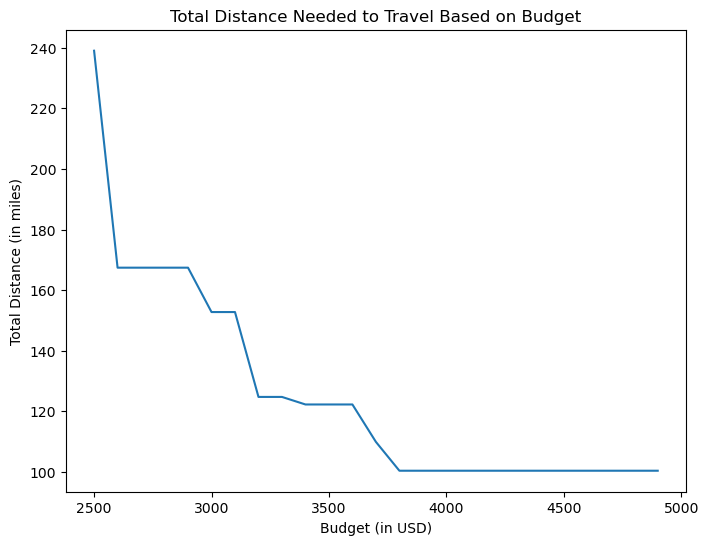

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

distance1temp = m.data['distance'].records
distance1 = distance1temp[distance1temp.level > 0]

dist = m.data['tot_dist'].records
budget = m.data['budget'].records
fig, ax = plt.subplots(figsize=(8,6))
ax.set_title("Total Distance Needed to Travel Based on Budget")
ax.set_xlabel("Budget (in USD)")
ax.set_ylabel("Total Distance (in miles)")

# Plotting total distance vs rent budget
ax.plot(budget['value'] ,dist['value'])

### Results

When fixing my budget to be the absolute maxiumum I am willing to spend on rent in a given month, my total distance traveled was approximately **100 miles**. The graph above shows after about \\$3,800 (the high end of my budget), there is no benefit to increasing my budget, indicating this is the general solution to minimize total distance optimal. However, there is only a slight difference in distance of approximately 25 miles between a budget of \\$3,800 and a budget of about **\\$3,200**.

Given that over the course of 3 months I would be saving about **\\$1,800** on rent, I believe traveling an extra 25 miles (which is an overestimate of distance since I may not travel to all locations in a given week) is worth this trade off. Therefore, I solved the model again with the optimal budget value from the graph above. 

In [12]:
%%gams
lbudget = 3200 ;
solve NYC1 minimizing total_dist using mip ;

Solver Status        Model Status  Objective #equ #var Model Type Solver  \
0    Normal (1)  Optimal Global (1)   124.7638  509  529        MIP  CPLEX   

  Solver Time  
0           0

In [13]:
live = m.data['live'].records
distance = m.data['distance'].records[m.data['distance'].records.level > 0]
neighborhood = live[live.level==1.0].n_0.values[0]
gams.pivot2d(distance).transpose()
# Distance from each location to Hell's Kitchen in miles

Hell's Kitchen
West_Monroe               0.311364
Citi                      3.150139
Gym                       2.334632
Target1                   0.695902
Target2                   0.457023
Target3                   0.930523
WholeFoods1               0.725269
WholeFoods2               1.294455
WholeFoods3               1.400313
Coffee1                   0.458985
Coffee2                   0.500025
Coffee3                   1.445712
Bar1                      0.719984
Bar2                      1.774512
Restaurant_Burger         0.253746
Restaurant_Italian        0.355234
Restaurant_Pizza          0.669117
Restaurant_Chinese        0.133417
Subway1                   0.453378
Subway2                   1.057427
Subway3                   2.074137
Subway4                   2.133612
Subway5                   2.798145

In [14]:
# define the UTM zone for Lower Manhattan
utm_zone = '32618'
center_loc = [40.74886741305982, -73.98685883748408]

# create a base map in UTM coordinates
lower_manhattan_map = folium.Map(
    location=center_loc,
    zoom_start=13,
    control_scale=True,
    tiles='Stamen Terrain'
)

# add markers
for i in locations:
    if i == 'West_Monroe' or i == 'Citi':
        icon=folium.Icon(color='white', icon="briefcase", icon_color="black", prefix='fa')
        folium.Marker([locations[i][0], locations[i][1]], icon=icon, tooltip=i).add_to(lower_manhattan_map)
    elif "Target" in i:
        icon=folium.Icon(color='white', icon="dot-circle-o", icon_color="red", prefix='fa')
        folium.Marker([locations[i][0], locations[i][1]], icon=icon, tooltip=i).add_to(lower_manhattan_map)
    elif "WholeFoods" in i:
        icon=folium.Icon(color='white', icon="apple", icon_color="green", prefix='fa')
        folium.Marker([locations[i][0], locations[i][1]], icon=icon, tooltip=i).add_to(lower_manhattan_map)
    elif "Restaurant" in i:
        icon=folium.Icon(color='white', icon="cutlery", icon_color="gray", prefix='fa')
        folium.Marker([locations[i][0], locations[i][1]], icon=icon, tooltip=i).add_to(lower_manhattan_map)
    elif "Subway" in i:
        icon=folium.Icon(color='white', icon="train", icon_color="blue", prefix='fa')
        folium.Marker([locations[i][0], locations[i][1]], icon=icon, tooltip=i).add_to(lower_manhattan_map)
    elif "Coffee" in i:
        icon=folium.Icon(color='white', icon="coffee", icon_color="brown", prefix='fa')
        folium.Marker([locations[i][0], locations[i][1]], icon=icon, tooltip=i).add_to(lower_manhattan_map)
    elif "Bar" in i:
        icon=folium.Icon(color='white', icon="beer", icon_color="gold", prefix='fa')
        folium.Marker([locations[i][0], locations[i][1]], icon=icon, tooltip=i).add_to(lower_manhattan_map)
    else:
        icon=folium.Icon(color='white', icon="heartbeat", icon_color="magenta", prefix='fa')
        folium.Marker([locations[i][0], locations[i][1]], icon=icon, tooltip=i).add_to(lower_manhattan_map)

live_n = {'type': 'FeatureCollection', 'features': []}
for feature in new_json['features']:
    if feature['properties']['NTAName'] == neighborhood:
        live_n['features'].append(feature)
    else:
        continue

g = folium.GeoJson(live_n, style_function=style_function ).add_to(lower_manhattan_map)
folium.features.GeoJsonPopup(fields=["NTAName"], labels=False).add_to(g)
    
# display the map
lower_manhattan_map

The neighborhood with a median studio rental price within the optimal tradeoff budget that minimizes my total travel distance is **Hell's Kitchen**. Above is a visualization of the neighborhood in relation to the locations. 

However, Hell's Kitchen is a large neighborhood, and living in one location within the region could be drastically different from living in another when calculating total traveling distance and time spent traveling. Therefore, determining the ideal location to live within this neighborhood could prove to be very useful.

## Stage 2: Determining *Where* in the Neighborhood

To determine this, I used a formulation very similar to a sylvester optimization model, where instead of minimizing the radius of the smallest enclosing sphere I minimized the sum of the product of the distance to each location and its relative weight ($w_{\ell}$). The objective of this model is to determine an optimal location within Hell's Kitchen that minimizes the total distance needed to travel. Inherently, this will also minimize my total time and cost of traveling since both time and cost are strictly increasing functions of distance. 

There will be an additional dataset utilized that contains the $x$ and $y$ ranges for each neighborhood. I denote a set $coordbound$ which contains $xmin, xmax, ymin, ymax$. The parameter $bound_{n,coordbound}$ will hold this data. It must be noted that many regions are oddly shaped and for modeling purposes I took the minimum and maximum $x$ and $y$ coordinates to be the neighborhoods respective bounds. These coordinates are used to bound my optimal location to the neighborhood determined in Stage 1 to ensure the rent price is within my budget.

\**Note: Estimating the regions as a rectangle could cause the final location to be slightly outside of the Hell's Kitchen, but close enough that we will assume pricing for apartments still holds.*

In [15]:
bounds = {}
for feature in new_json["features"]:
    latitudes = [point[1] for point in feature["geometry"]["coordinates"][0]]
    longitudes = [point[0] for point in feature["geometry"]["coordinates"][0]]
    min_latitude = min(latitudes)
    min_longitude = min(longitudes)
    max_latitude = max(latitudes)
    max_longitude = max(longitudes)
    xmin, ymin, zone, u = utm.from_latlon(min_latitude, min_longitude)
    xmax, ymax, zone, u = utm.from_latlon(max_latitude, max_longitude)
    bound_list = [xmin/1609, xmax/1609,ymin/1609, ymax/1609]
    bounds[feature['properties']['NTAName']] = bound_list
    
bound = m.addParameter('bound', [n, coord_bound], description='Bounds on Neighborhood', records=np.array(list(bounds.values())))

### Formulation

The model takes in a variable which represents the optimal location to live within Hell's Kitchen. It contains a distance calculation to each location in $\ell$. The model then determines the optimal location by minimizing the total distance traveled. A detailed formulation is below.

For reference, the formulation involves these aspects of the formulation for the model in Stage 1:

- $\ell$ : set of 22 locations, for formulation purposes let $\ell = 1,2,...,L$
- $n$ : set of 22 neighborhoods, for for formulation purposes let $n = 1,2,...,N$
- $data_{\ell xy}$ : the coordinates for each location
- $w_\ell$ : the weight of each location (assigned by the modeler)

I also define the following variable:

- $home_{xy}$ : Optimal coordinates for my place of residence

The sylvester like model to find an optimal place to live that minimizes total distance traveled can the be solved by:
\begin{align*}
\min_{w_{\ell}, d_\ell} & \left( \sum_{i=1}^{L} w_i d_i\right) \\ 
\text{where  } & d_\ell = \sqrt{(home_{x} - data_{\ell x})^2 + (home_{y} - data_{\ell y})^2}\\
\text{subject to}\\
& bound_{n, xmin} \le home_x \le bound_{n,xmax}\\
& bound_{n, ymin} \le home_y \le bound_{n,ymax}\\ 
\text{ where $n$ = Hell's Kitchen}
\end{align*}

However, this must be reformulated due to the square root within the distance calculation, which will cause GAMS to throw an error. Therefore, the problem can be reformulated as

\begin{align*}
\min_{w_{\ell},d_\ell} & \left( \sum_{i=1}^{L} w_i d_i\right) \\ 
\text{where  } & d_\ell^2 = (home_{x} - data_{\ell x})^2 + (home_{y} - data_{\ell y})^2\\
\text{subject to}\\
& bound_{n, xmin} \le home_x \le bound_{n,xmax}\\
& bound_{n, ymin} \le home_y \le bound_{n,ymax}\\ 
\text{ where $n$ = Hell's Kitchen}
\end{align*}

### Solving the Model

In [16]:
%%gams
    
variables
    diff(l,coord)
    d(l)
    home(coord)
    objective ;

equations
    def_diff(l, coord)
    def_distance(l)
    obj_eqn
;

def_diff(l, coord)..
    diff(l, coord) =E= home(coord) - data(l, coord) ;
    
def_distance(l)..
    sqr(d(l)) =G= sum(coord, sqr(diff(l, coord))) ;
    
obj_eqn..
    objective =E= sum(l, w(l)*d(l));

model NYC /def_diff, def_distance, obj_eqn / ;

home.lo('x') = bound("Hell's Kitchen", 'xmin') ;
home.up('x') = bound("Hell's Kitchen", 'xmax') ;
home.lo('y') = bound("Hell's Kitchen", 'ymin') ;
home.up('y') = bound("Hell's Kitchen", 'ymax') ;

d.l(l) = smax((coord), abs(data(l,coord)));
d.lo(l) = 0; d.up(l) = 1.2*d.l(l);

option qcp=cplex ;
solve NYC using qcp minimizing objective ;
*Objective value is total traveling distance in miles.

Solver Status        Model Status  Objective #equ #var Model Type Solver  \
0    Normal (1)  Optimal Global (1)    96.3506   70   72        QCP  CPLEX   

  Solver Time  
0           0

In [17]:
home = m.data['home'].records
# converting coordinates back to longitude and latitude
final = utm.to_latlon(home.level[0]*1609, home.level[1]*1609, 18, 'N')
# Display final optimal location
final

(40.75459247399236, -73.98965663727104)

In [18]:
icon_final = folium.Icon(color='red', icon="home", icon_color="black", prefix='fa')
folium.Marker([final[0], final[1]], icon=icon_final, tooltip="Living Quarters", ).add_to(lower_manhattan_map)
lower_manhattan_map

### Results

The model found an optimal solution with geographical coordinates of approximately **40.7546&deg;N, -73.9897&deg;E** (denoted by the red icon above) and my total distance traveled would be approximately **96.35 miles**. The location does appear to be slightly outside of the NYC's government definition of Hell's Kitchen, but this is most likely to due to a combination of estimating the region to be a rectangle as well as some error from converting UTM coordinates to geographical coordinates. Even so, the location is still only half a block outside of the Hell's Kitchen neighborhood. One could simply alter the bounds manually until the point gets is barely within the region, but this is not best practice in general.

It would also be interesting to see how the distance to each location has improved from the model in Stage 1 (using the centroid) to the model in Stage 2 (using the optimal location). 

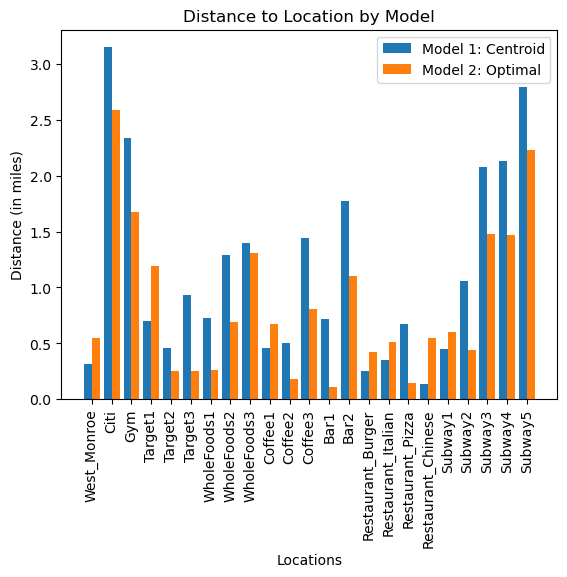

In [19]:
distance2 = m.data['d'].records
xaxis = list(distance2.l_0)
yaxis1 = list(distance.level)
yaxis2 = list(distance2.level)

X_axis = np.arange(len(xaxis))

plt.bar(X_axis - 0.2, yaxis1, 0.4, label = 'Model 1: Centroid')
plt.bar(X_axis + 0.2, yaxis2, 0.4, label = 'Model 2: Optimal')
plt.xticks(X_axis, xaxis, rotation=90)
plt.xlabel("Locations")
plt.ylabel("Distance (in miles)")
plt.title("Distance to Location by Model")
plt.legend()

# Plot how distance to each location improves by living in the optimal location
plt.show()

The optimal location decreases the total distance by about **28 miles as well as decreasing the distance to almost every location** (the exceptions will always be present if we deviate any marginal amount from the centroid location). Therefore, solving the 'sylvester-like' model was incredibly useful and will also result in minimizing time and help me get more for my money (since both are strictly increasing functions of distance). 

Now for the fun part. Let's see what is actually at this location! Google shows this to be a commercial building with various stores and some apartments are nearby!

[Google Maps Link](https://www.google.com/maps/search/apartments/@40.7545696,-73.990761,18z/data=!4m7!2m6!3m5!1sapartments!2s40.7545925,-73.9896566!4m2!1d-73.9896566!2d40.7545925)

| 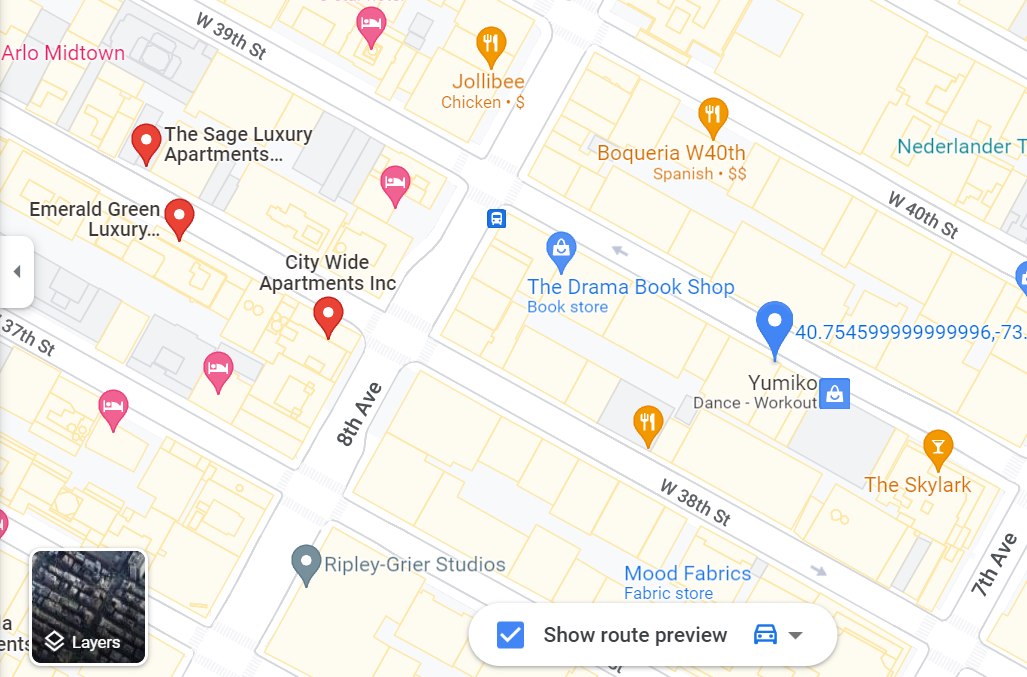| 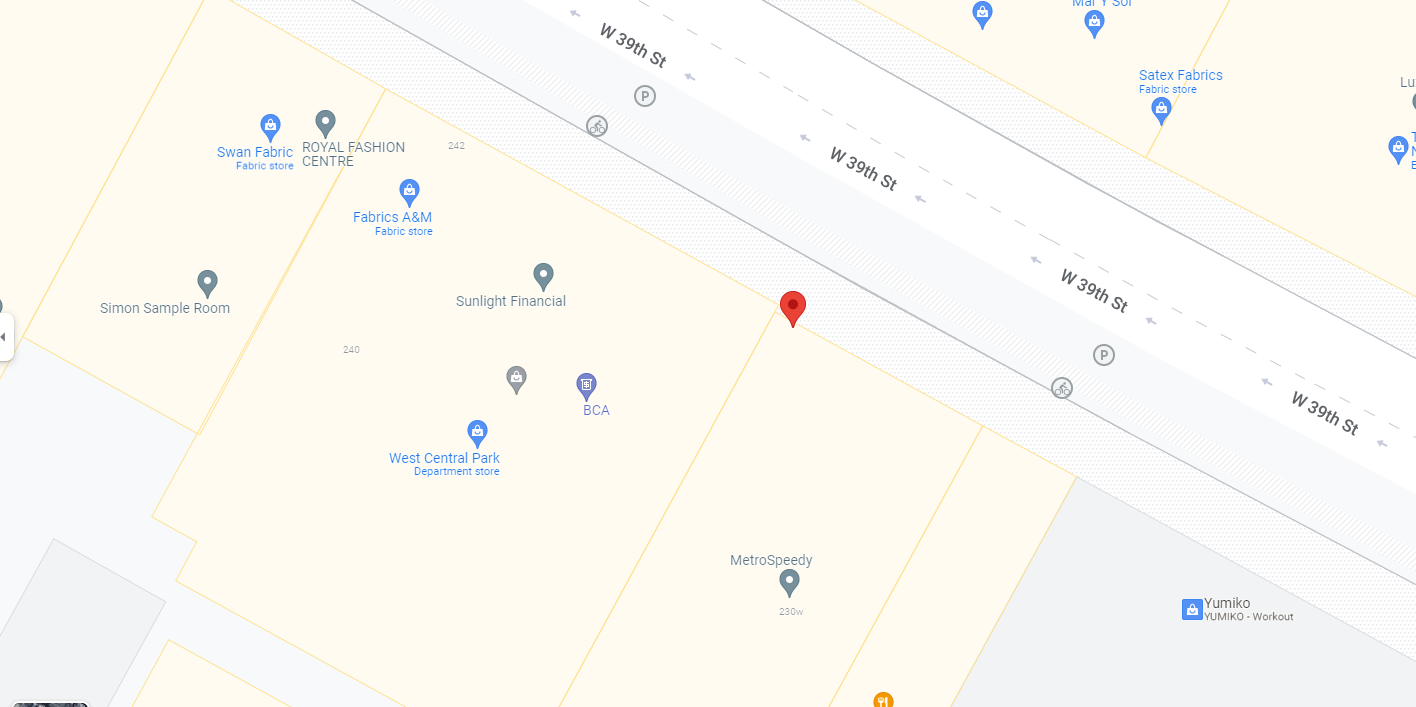  |
|-|-|
| 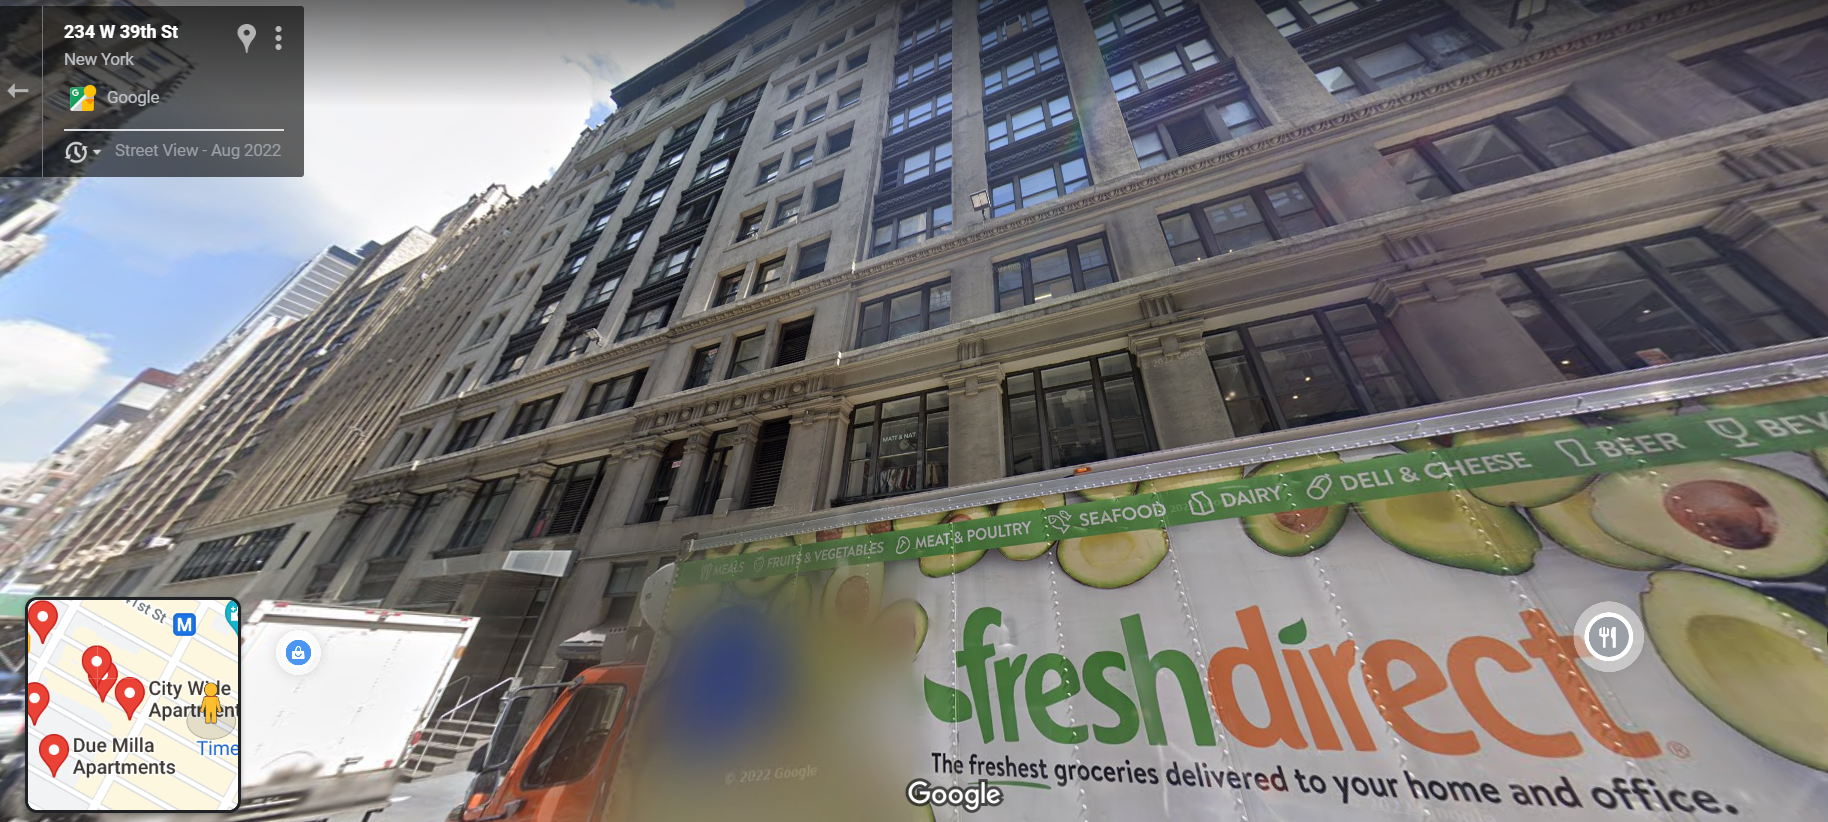 |

## Stage 3: Determining *how* to get to each Location

As noted in the problem description, I want to get a good idea for how I should travel to each location. An optimization model proves to be useful since there are a **many** different combinations of methods to choose from and doing so by hand is nearly impossible. The model takes in a distance and computes a time and cost to each $\ell$ for every transportation method. It chooses the optimal methods, which is done by implementing a binary variable. The objective of the model is to minimize my total travel time while keeping the cost within my transportation budget. The formulations for cost and time from a given distance in miles are described below.

### Data

I considered 3 methods of transportation that I am able to take at any given time in NYC. Those 3 methods are:
- **Walking**
- **The Subway**
- **Ubering**

As noted above, the only information I can calculate given the UTM coordinates is distance. Therefore, I must have a method for determining a time and cost given a distance. The time and cost to for each method are referred to as $time_{method}$ and $cost_{method}$. The formulas and justification for these formulas for each transportation method are denoted below:

#### <u>Walking</u>

**Cost**: There is no need to determine a cost for walking since it is always free (often just inconvenient or tiresome). Therefore, the cost for walking is **0**. $$cost_{walk} = 0$$\
**Time**: At the gym, I frequently walk at a pace of 3.5 miles per hour on a treadmill, but this speed feels slightly faster than my casual walking speed. Based on this, I assume my walking pace to be 3 miles per hour. Denoting my walking speed as $s_{walk}$ and distance to walk as $d_{walk}$, calculating time in minutes can be determined by solving $$time_{walk} = d_{walk}*(60 / s_{walk} )$$

#### <u>The Subway</u>
**Cost**: Based on the information from the Metropolitan Transportation Authority found at [mta.info](https://new.mta.info/fares), a subway ticket for a one way ride is **\$2.75**. The cost to ride the subway does not depend on distance and can be denoted as: $$cost_{subway} = 2.75$$

**Time**: According to [NYTimes](https://www.nytimes.com/2018/12/10/nyregion/new-york-subway-delay.html), a transportation report conducted in 2010 found the average NYC subway travels at a speed of **17 miles per hour**. Additionally, I assume walking to and waiting for the subway takes approximately 5 minutes (since there are smaller subway stations scattered all throughout New York). Denoting subway waiting time as $wait_{subway}$, subway speed as $s_{subway}$, and distance to ride the subway as $d_{subway}$, calculating time in minutes can be determined by solving $$time_{subway} = wait_{subway} + d_{subway}*(60 / s_{subway} )$$

#### <u>Ubering</u>

**Cost**: According to [Investopedia](https://www.investopedia.com/articles/personal-finance/021015/uber-versus-yellow-cabs-new-york-city.asp), Uber's pricing system for NYC consists of a **\$2.55 base fare** and **\$0.35 per minute** and **\$1.75 per mile** fees. It should be noted that time is one of the aspects I am estimating and even though it utilizes adequate sources and logic, it may deviate from the true value. Therefore, I formulated my Uber cost as only a function of distance, since this is a known value from Stage 2. The \\$0.35 per minute fee will be converted to an additional **\\$1.40 per mile** (since speed is about 16 mph) to give a true per mile cost of **\\$3.15**. I denoted these values as $base$ and $pmile$ respectively. Letting $d_{uber}$ represent the distance traveled in the Uber, the cost for an Uber can be determined by $$cost_{uber} = base + pmile*d_{uber}$$

**Time**: From a dataset about Real-Time Traffic Speed Data found on [data.cityofnewyork.us](https://data.cityofnewyork.us/Transportation/DOT-Traffic-Speeds-NBE/i4gi-tjb9), the median traffic speed for Manhattan is approximately **16.15 miles per hour**. Additionally, due to past experience and New York's reputation, I assume the time between ordering the Uber and its arrival to be about **2 minutes**. Denoting uber speed as $s_{uber}$ and uber wait time as $wait_{uber}$, calculating time in minutes can be determined by solving $$time_{uber} = d_{uber}*(60 /s_{uber} ) + wait_{uber}$$


In [20]:
# Getting median speed of traffic in Manhattan
import statistics
with open("uberspeed.json") as u:
    uber_speed = json.load(u)
speed_list = []
for i in uber_speed:
    if i['borough'] == 'Manhattan':
        speed_list.append(float(i['speed']))
statistics.median(speed_list)

16.15

To set this up for the formulation, I denote a set $tran$ that contains all three transportation methods in the order of $walk$, $subway$, $uber$. I represent the parameter used in the formulation below as the initial line and it's corresponding values as the bullets below:

- $s_{tran}$ : speed
    * $s_{walk} = 3$
    * $s_{subway} = 17$
    * $s_{uber} = 16.15$
- $wait_{tran}$ : waiting time
    * $wait_{walk} = 0$
    * $wait_{subway} = 5$
    * $wait_{uber} = 2$
- $base_{tran}$ : base fare
    * $base_{walk} = 0$
    * $base_{subway} = 2.75$
    * $base_{uber} = 2.55$
- $dfare_{tran}$ : fare for each mile
    * $dfare_{walk} = 0$
    * $dfare_{subway} = 0$
    * $dfare_{uber} = 3.15$

### Formulation

The model takes in the predefined distance to each location ($d_\ell$) from Stage 2. I utilize the following aspects of previous models:

- $\ell$ : set of 22 locations, for formulation purposes let $\ell = 1,2,...,L$
- $w_\ell$ : the weight of each location (assigned by the modeler)


I also define the new set $tran$:

- $tran$ : Set of 3 transportation methods, for formulation purposes let $trans = 1,2,...,T$

The values for the cost and time formulation for each transportation method are denoted using the representations defined above:

- $s_{tran}$ : speed
- $wait_{tran}$ : waiting time
- $base_{tran}$ : base fare
- $dfare_{tran}$ : fare for each mile

Addtionally, there are the following scalar values:

- $tbudget = 250$ : my original budget for transportation costs (weekly basis)

I also define the following variables:

- $t_\ell$ : time to travel to location $\ell$ (only including one trip, not multiplied by weights)
- $c_\ell$ : cost to travel to location $\ell$ (total cost to location, weights included)
- $method_{\ell, tran}$ : a binary variable to determine which transportation method I take to location $\ell$

The model to determine the optimal location that minimizes my total transportation costs and time can be solved by:

\begin{align*}
\min_{t_\ell} & \left( \sum_{i=1}^{L} w_i t_i\right) \\ 
& \\
\text{subject to}\\
& \sum_{j=1}^{T} method_{\ell j} = 1  \text{  for $\ell=1,\ldots,L$}\\
& \sum_{i=1}^{L} c_i \le tbudget\\
\text{where $d_{\ell}$ are the distance values determined in Stage 2 and }\\
& c_\ell = w_{\ell} \sum_{j=1}^{T} method_{\ell j}*(base_j + d_\ell*dfare_j) \text{  for $\ell=1,\ldots,L$}\\
& t_\ell = \sum_{j=1}^{T} method_{\ell j} * (wait_j + d_{\ell}*(60/s_j)) \text{  for $\ell=1,\ldots,L$}\\
\end{align*}

Additionally, I fix some values to say I must take a certain transportation method due to feasibility. I indicate to the model that I must either walk or subway to both the my work and the gym, since I would never take an Uber to these locations every single day.

\begin{align*}
method_{WestMonroe, uber} = 0 \\
method_{Gym, uber} = 0
\end{align*}

In [21]:
%%gams

scalars   
    tbudget /250/ ;  
    
variables
    c(l)
    t(l)
    total_time
    total_cost
    min_time ;
 
set tran /walk, subway, uber/ ;
parameter s(tran) miles per hour /walk 3, subway 17, uber 16.15/ ;
parameter wait(tran) wait time /walk 0, subway 5, uber 2/ ;
parameter base(tran) base fee /walk 0, subway 2.75, uber 2.55/;
parameter fare_d(tran) fare per method (distance) /walk 0, subway 0, uber 3.15/;
sos1 variable method(l, tran) ;


equations
    def_time(l)
    time_eq total time spent traveling
    def_cost(l)
    cost_eqn total money spent traveling
    budget_tcon
    t_con(l)
    objective_eqn
;

def_time(l)..
    t(l) =E= sum(tran,
                method(l, tran)*(wait(tran) + d.l(l)*(60/s(tran)))) ;

time_eq..
    total_time =E= sum(l, w(l)*t(l)) ;

def_cost(l)..
    c(l) =E= w(l)*sum(tran,
                method(l, tran)*(base(tran) + fare_d(tran)*d.l(l))) ;
    
cost_eqn..
    total_cost =E= sum(l, c(l)) ;

budget_tcon..
    sum(l, c(l)) =L= tbudget ;

t_con(l)..
    sum(tran, method(l, tran)) =E= 1 ;
    
objective_eqn..
    min_time =E= total_time ;

model NYCfinal / def_time, time_eq, def_cost, cost_eqn, budget_tcon, t_con, objective_eqn / ;

method.fx('West_Monroe', 'uber') = 0 ;
method.fx('Gym', 'uber') = 0 ;


option mip=cplex ;
NYCfinal.optcr=10e-8 ;
solve NYCfinal using mip minimizing min_time ;


Solver Status        Model Status  Objective #equ #var Model Type Solver  \
0    Normal (1)  Optimal Global (1)   716.8793   73  118        MIP  CPLEX   

  Solver Time  
0           0

In [22]:
home = m.data['home'].records
cost = m.data['c'].records
time = m.data['t'].records
method = m.data['method'].records
df = gams.pivot2d(method)
df[df.index == 'West_Monroe']['walk'][0]

final_map = folium.Map(
    location=center_loc,
    zoom_start=13,
    control_scale=True,
    tiles='Stamen Terrain'
)


folium.Marker([final[0], final[1]], icon=icon_final, tooltip="Living Quarters").add_to(final_map)

# add markers

for i in locations:
    if i == 'West_Monroe' or i == 'Citi':
        icon=folium.Icon(color='white', icon="briefcase", icon_color="black", prefix='fa')
        folium.Marker([locations[i][0], locations[i][1]], icon=icon, tooltip=i).add_to(final_map)
    elif "Target" in i:
        icon=folium.Icon(color='white', icon="dot-circle-o", icon_color="red", prefix='fa')
        folium.Marker([locations[i][0], locations[i][1]], icon=icon, tooltip=i).add_to(final_map)
    elif "WholeFoods" in i:
        icon=folium.Icon(color='white', icon="apple", icon_color="green", prefix='fa')
        folium.Marker([locations[i][0], locations[i][1]], icon=icon, tooltip=i).add_to(final_map)
    elif "Restaurant" in i:
        icon=folium.Icon(color='white', icon="cutlery", icon_color="gray", prefix='fa')
        folium.Marker([locations[i][0], locations[i][1]], icon=icon, tooltip=i).add_to(final_map)
    elif "Subway" in i:
        icon=folium.Icon(color='white', icon="train", icon_color="blue", prefix='fa')
        folium.Marker([locations[i][0], locations[i][1]], icon=icon, tooltip=i).add_to(final_map)
    elif "Coffee" in i:
        icon=folium.Icon(color='white', icon="coffee", icon_color="brown", prefix='fa')
        folium.Marker([locations[i][0], locations[i][1]], icon=icon, tooltip=i).add_to(final_map)
    elif "Bar" in i:
        icon=folium.Icon(color='white', icon="beer", icon_color="gold", prefix='fa')
        folium.Marker([locations[i][0], locations[i][1]], icon=icon, tooltip=i).add_to(final_map)
    else:
        icon=folium.Icon(color='white', icon="heartbeat", icon_color="magenta", prefix='fa')
        folium.Marker([locations[i][0], locations[i][1]], icon=icon, tooltip=i).add_to(final_map)

    df_method = gams.pivot2d(method)
    line_coordinates = [ [final[0], final[1]],
                         [locations[i][0], locations[i][1]]
                       ]
    if df_method[df.index == i]['walk'][0] == 1.0:
        folium.PolyLine(locations=line_coordinates, color='red', weight=2.5, opacity=1, tooltip='Walk').add_to(final_map)
    elif df_method[df.index == i]['subway'][0] == 1.0:
        folium.PolyLine(locations=line_coordinates, color='purple', weight=2.5, opacity=1, tooltip='Subway').add_to(final_map)
    else:
        folium.PolyLine(locations=line_coordinates, color='blue', weight=2.5, opacity=1, tooltip='Uber').add_to(final_map)
    
gf = folium.GeoJson(live_n, style_function=style_function ).add_to(final_map)
folium.features.GeoJsonPopup(fields=["NTAName"], labels=False).add_to(gf)

# Display map with solution from predetermined budget value
final_map

It would also be interesting to do a similar analysis to that done in Stage 1 to see how altering my transportation budget impacts my total time traveled. To do so, I solve the model above numerous times with transportation budgets ranging from \$50-$450 (I would never spend \$450 on transportation but let's see how small my travel time can get).

In [23]:
%%gams
set i /1*40/ ;
parameter tran_budget(i) ;
tran_budget(i)  = 50 + (i.val-1)*10 ;

parameter travel_time(i);

loop(i,
    tbudget = tran_budget(i) ;
    NYCfinal.optcr=10e-8 ;
    solve NYCfinal using mip minimizing min_time;
    if (NYCfinal.ModelStat le 2,
        travel_time(i) = min_time.l ;)
        )
*Change tbudget values and see how total travel time changes.        

Solver Status        Model Status  Objective #equ #var Model Type Solver  \
0     Normal (1)  Optimal Global (1)  1394.7746   73  118        MIP  CPLEX   
1     Normal (1)  Optimal Global (1)  1361.5218   73  118        MIP  CPLEX   
2     Normal (1)  Optimal Global (1)  1250.9342   73  118        MIP  CPLEX   
3     Normal (1)  Optimal Global (1)  1168.2078   73  118        MIP  CPLEX   
4     Normal (1)  Optimal Global (1)  1108.5814   73  118        MIP  CPLEX   
5     Normal (1)  Optimal Global (1)  1019.3839   73  118        MIP  CPLEX   
6     Normal (1)  Optimal Global (1)   960.9695   73  118        MIP  CPLEX   
7     Normal (1)  Optimal Global (1)   934.5959   73  118        MIP  CPLEX   
8     Normal (1)  Optimal Global (1)   904.0028   73  118        MIP  CPLEX   
9     Normal (1)  Optimal Global (1)   881.5884   73  118        MIP  CPLEX   
10    Normal (1)  Optimal Global (1)   863.7007   73  118        MIP  CPLEX   
11    Normal (1)  Optimal Global (1)   846.3704   73  118        MIP  CPLEX   
12    Normal (1)  Optimal Global (1)   831.4367   73  118        MIP  CPLEX   
13    Normal (1)  Optimal Global (1)   814.1064   73  118        MIP  CPLEX   
14    Normal (1)  Optimal Global (1)   802.0749   73  118        MIP  CPLEX   
15    Normal (1)  Optimal Global (1)   784.7447   73  118        MIP  CPLEX   
16    Normal (1)  Optimal Global (1)   773.2000   73  118        MIP  CPLEX   
17    Normal (1)  Optimal Global (1)   759.1381   73  118        MIP  CPLEX   
18    Normal (1)  Optimal Global (1)   747.6444   73  118        MIP  CPLEX   
19    Normal (1)  Optimal Global (1)   730.9910   73  118        MIP  CPLEX   
20    Normal (1)  Optimal Global (1)   716.8793   73  118        MIP  CPLEX   
21    Normal (1)  Optimal Global (1)   711.1795   73  118        MIP  CPLEX   
22    Normal (1)  Optimal Global (1)   700.0639   73  118        MIP  CPLEX   
23    Normal (1)  Optimal Global (1)   694.4741   73  118        MIP  CPLEX   
24    Normal (1)  Optimal Global (1)   685.9062   73  118        MIP  CPLEX   
25    Normal (1)  Optimal Global (1)   680.3940   73  118        MIP  CPLEX   
26    Normal (1)  Optimal Global (1)   672.6037   73  118        MIP  CPLEX   
27    Normal (1)  Optimal Global (1)   667.3479   73  118        MIP  CPLEX   
28    Normal (1)  Optimal Global (1)   661.0179   73  118        MIP  CPLEX   
29    Normal (1)  Optimal Global (1)   655.5057   73  118        MIP  CPLEX   
30    Normal (1)  Optimal Global (1)   648.6784   73  118        MIP  CPLEX   
31    Normal (1)  Optimal Global (1)   643.1662   73  118        MIP  CPLEX   
32    Normal (1)  Optimal Global (1)   637.2097   73  118        MIP  CPLEX   
33    Normal (1)  Optimal Global (1)   632.6937   73  118        MIP  CPLEX   
34    Normal (1)  Optimal Global (1)   631.9903   73  118        MIP  CPLEX   
35    Normal (1)  Optimal Global (1)   627.6504   73  118        MIP  CPLEX   
36    Normal (1)  Optimal Global (1)   622.6901   73  118        MIP  CPLEX   
37    Normal (1)  Optimal Global (1)   617.1779   73  118        MIP  CPLEX   
38    Normal (1)  Optimal Global (1)   616.4745   73  118        MIP  CPLEX   
39    Normal (1)  Optimal Global (1)   616.4745   73  118        MIP  CPLEX   

   Solver Time  
0        0.016  
1            0  
2        0.015  
3        0.015  
4        0.016  
5        0.016  
6        0.016  
7        0.015  
8        0.016  
9            0  
10           0  
11           0  
12       0.016  
13           0  
14       0.015  
15       0.015  
16       0.016  
17           0  
18       0.016  
19       0.015  
20           0  
21       0.015  
22       0.016  
23       0.015  
24           0  
25       0.016  
26           0  
27       0.016  
28       0.016  
29           0  
30           0  
31           0  
32           0  
33           0  
34       0.016  
35       0.016  
36       0.016  
37           0  
38           0  
39       0.015

\**Originally, some of the model statuses were 8 meaning an integer solution was found. To get a global optimal solution, I set the model optcr to be $10^{-8}$ and this tolerance allowed an optimal global solution to be found for all budgets.*

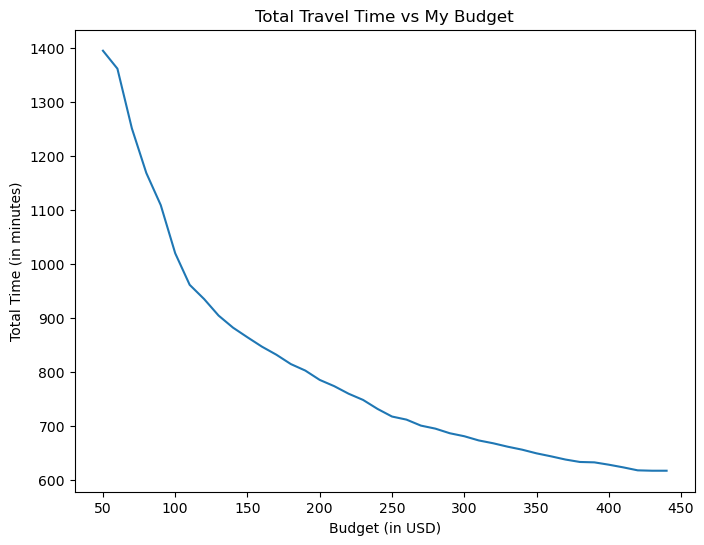

In [24]:
time = m.data['travel_time'].records
tran_budget = m.data['tran_budget'].records
fig, ax = plt.subplots(figsize=(8,6))
ax.set_title("Total Travel Time vs My Budget")
ax.set_xlabel("Budget (in USD)")
ax.set_ylabel("Total Time (in minutes)")

# Plotting how time changes when my budget changes
ax.plot(tran_budget['value'] , time['value'])

The graph above shows that varying budget does show some diminishing returns as the transportation budget gets larger and larger. It isn't your typical Pareto Optimal curve, but it will still help me decide on an optimal budget by finding the budget value where the marginal returns to time begin to become insignificant. 

\**Marginal returns in this case refers to how much time is saved by increasing my budget. Diminishing returns refers to how after a specific threshold (or budget value) my returns become significantly smaller and smaller.*

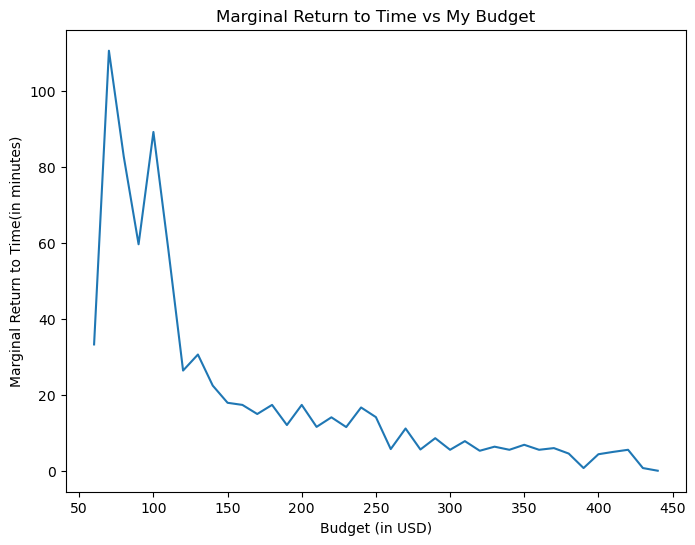

In [25]:
time_initial = np.array(time['value'])
diff_list = np.diff(time_initial).tolist()
diff_list.insert(0,0)
m_return = [-number for number in diff_list]     
fig, ax = plt.subplots(figsize=(8,6))
ax.set_title("Marginal Return to Time vs My Budget")
ax.set_xlabel("Budget (in USD)")
ax.set_ylabel("Marginal Return to Time(in minutes)")

# Plot marginal return vs my budget, marginal return for first value is always 0 so we exclude it
ax.plot(tran_budget['value'][1:] , m_return[1:])

The graph is noisy which I assume is due to the model changing methods (which changes total time) each time the budget increases. However, the marginal returns to time start to become significantly smaller at a budget of around **\$160**. One could also argue that \$200 or \$240 could be an optimal budget value due to larger marginal returns relative to local values, but I want to save money so a budget value of **\$160** is used.

In [26]:
%%gams
tbudget = 160;
NYCfinal.optcr=10e-8 ;
solve NYCfinal using mip minimizing min_time ;

Solver Status        Model Status  Objective #equ #var Model Type Solver  \
0    Normal (1)  Optimal Global (1)   846.3704   73  118        MIP  CPLEX   

  Solver Time  
0       0.016

In [27]:
home = m.data['home'].records
cost = m.data['c'].records
time = m.data['t'].records
method = m.data['method'].records
df = gams.pivot2d(method)
df[df.index == 'West_Monroe']['walk'][0]

final_map2 = folium.Map(
    location=center_loc,
    zoom_start=13,
    control_scale=True,
    tiles='Stamen Terrain'
)


folium.Marker([final[0], final[1]], icon=icon_final, tooltip="Living Quarters").add_to(final_map2)

# add markers

for i in locations:
    if i == 'West_Monroe' or i == 'Citi':
        icon=folium.Icon(color='white', icon="briefcase", icon_color="black", prefix='fa')
        folium.Marker([locations[i][0], locations[i][1]], icon=icon, tooltip=i).add_to(final_map2)
    elif "Target" in i:
        icon=folium.Icon(color='white', icon="dot-circle-o", icon_color="red", prefix='fa')
        folium.Marker([locations[i][0], locations[i][1]], icon=icon, tooltip=i).add_to(final_map2)
    elif "WholeFoods" in i:
        icon=folium.Icon(color='white', icon="apple", icon_color="green", prefix='fa')
        folium.Marker([locations[i][0], locations[i][1]], icon=icon, tooltip=i).add_to(final_map2)
    elif "Restaurant" in i:
        icon=folium.Icon(color='white', icon="cutlery", icon_color="gray", prefix='fa')
        folium.Marker([locations[i][0], locations[i][1]], icon=icon, tooltip=i).add_to(final_map2)
    elif "Subway" in i:
        icon=folium.Icon(color='white', icon="train", icon_color="blue", prefix='fa')
        folium.Marker([locations[i][0], locations[i][1]], icon=icon, tooltip=i).add_to(final_map2)
    elif "Coffee" in i:
        icon=folium.Icon(color='white', icon="coffee", icon_color="brown", prefix='fa')
        folium.Marker([locations[i][0], locations[i][1]], icon=icon, tooltip=i).add_to(final_map2)
    elif "Bar" in i:
        icon=folium.Icon(color='white', icon="beer", icon_color="gold", prefix='fa')
        folium.Marker([locations[i][0], locations[i][1]], icon=icon, tooltip=i).add_to(final_map2)
    else:
        icon=folium.Icon(color='white', icon="heartbeat", icon_color="magenta", prefix='fa')
        folium.Marker([locations[i][0], locations[i][1]], icon=icon, tooltip=i).add_to(final_map2)

    df_method = gams.pivot2d(method)
    line_coordinates = [ [final[0], final[1]],
                         [locations[i][0], locations[i][1]]
                       ]
    if df_method[df.index == i]['walk'][0] == 1.0:
        folium.PolyLine(locations=line_coordinates, color='red', weight=2.5, opacity=1, tooltip='Walk').add_to(final_map2)
    elif df_method[df.index == i]['subway'][0] == 1.0:
        folium.PolyLine(locations=line_coordinates, color='purple', weight=2.5, opacity=1, tooltip='Subway').add_to(final_map2)
    else:
        folium.PolyLine(locations=line_coordinates, color='blue', weight=2.5, opacity=1, tooltip='Uber').add_to(final_map2)
    
gf = folium.GeoJson(live_n, style_function=style_function ).add_to(final_map2)
folium.features.GeoJsonPopup(fields=["NTAName"], labels=False).add_to(gf)

final_map2

The plot above shows my transportation route to each location. 

\**Walk = **Red**, Subway = **Purple**, Uber = **Blue**. You can also hover over the line and it will display the method.* 

### Results

With a transportation budget of **\\$160**, my total traveling time would be approximately **846 minutes**. The model decided my primary mode of transportation to most locations would be the subway, which is exactly how I expected to get around Manhattan in the majority of cases. The maps generally show walking is optimal for short distances, Ubering is optimal for medium distances, and the subway is optimal for long distances. This is rather surprising to me as I typically trend towards Ubering long distances due to convenience, so this finding will hopefully save me a lot of time (and money) while in Manhattan.

## Conclusion

To decide the optimal location to live and transportation methods within Manhattan, I approached the problem with a hierachical goal programming approach.

The first stage determined the optimal neighborhood for me to live in, where the model originally chose Midtown South-Flatiron-Union Square with a total distance of about 100 miles. However, conducting sensitivity analysis on the total distance by changing my budget offered a different solution of **Hell's Kitchen** as the optimal neighborhood (in my situation). In comparison to Midtown South, Hell's Kitchen only increases total distance by about 25 miles but saves me about **\$2,000** over the course of the summer. 

The second stage determined my the optimal location to live within the Hell's Kitchen neighborhood. I formulated a quadratically constrained optimization problem similar to a sylvester model, where the objective was to minimize the sum of the product of the weights and distance to each location ($\sum_{i=1}^{L} w_i d_i$). The model determined the optimal location to be **40.7546&deg;N, -73.9897&deg;E** with a total distance of about **96.35 miles**. This turned out to be a corporate building, but there were numerous apartment buildings within half a block of these coordinates. I then examined the difference between this distance value and the objective value and distances from Stage 1 and found the optimal location decreased total travel distance by about 28 miles and decreased distance to the vast majority of locations (including my girlfriend's work which was a bonus).

The final stage determined the optimal way to get to each location while minimizing time and staying within my budget. With the original budget of about \\$250, the model determined an total travel time of about 717 minutes, or 11 hours and 57 minutes. Doing a similar sensitivity analysis to Stage 1, I determined an budget of \\$160 would be best since I want to minimize my cost and the marginal returns to time became increasingly stagnant after this value. Due to feasibility regions, I used introduced my tolerance level to find an optimal global solution of about **846 minutes**, or **14 hours and 6 minutes** (this is on the extreme high end because as referenced earlier, I won't travel to all locations in a given week at the corresponding weight). By conducting this analysis, I am able to save approximately **\\$900** over the summer while only traveling (at most) an additional 2 hours per week. 

Overall, using optimization models solve this problem helped me determine a good monthly budget estimate for rent (\\$3,160 per month for Hell's Kitchen) and transportation costs (\\$160 x 4 weeks) of **\\$3,800** while saving countless hours of calculations. This is a great start to planning my budget and gave insights into how I should start saving. Solving the problem in a three stage setup ensured all of my own constraints and objectives were met while still finding useful optimal solutions at each stage. By collecting the right data, this process could be done for a variety of different locations but Stage 3 worked particularly well for Manhattan due to the massive subway system and my own choice to not bring a car.

In [28]:
%gams_cleanup --closedown